## Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services
### In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

### The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Import the required libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [3]:
## Supervised Learning Model

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Functions to Clean, Transform and Cluster the dataset.
### The columns with 80% missing values are removed. 
### Replace all unknown values by numpy nan. 
### Use simple Imputer to fill the missing values
### Remove the highly correlated features
### Convert the categorical attributes into dummy variables

In [9]:
def clean_data(df):
    
    '''
    INPUT:
    
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    df2 - (pandas dataframe) Cleaned DataFrame 
    
    '''
    
    
    # Drop columns with 80% missing values
    
    cols=df.columns
    min=int(0.2*df.shape[0]+1)
    df.shape
    df.dropna(axis=1,thresh=min,inplace=True)
    cols1=df.columns
    print('Columns with 80% missing values are removed')
    
    # Replace unknown value with np.nan
    
    attrib=pd.read_excel('DIAS Attributes - Values 2017.xlsx',skiprows=1)
    cl=attrib[attrib.Meaning.str.contains('unknown',na=False)].Attribute.to_list()
    for c in cl:
        if(c in df.columns):
            df[c].replace([-1,0,9],np.nan,inplace=True)
    df.astype(df.dtypes)
    print('Unknown values are replaced by numpy nan values')
    
    # Use Simple Imputer to fill np.nan with most frequent value
    
    imp=SimpleImputer(missing_values=np.nan,strategy='most_frequent')
    imp.fit(df)
    dff=pd.DataFrame(imp.transform(df),columns=cols1).astype(df.dtypes)
    print('Simple Imputer with "most_frequent" as the strategy is used to fill missing values')
    
    # Remove highly correlated features
    
    col_num=dff.select_dtypes(include='number').columns.to_list()
    df_num=dff[col_num]
    correlations=df_num.corr()
    corr_cols=[]
    row=correlations.index
    col=correlations.columns
    for i in row:
        for j in col:
            if(i!=j and correlations[i][j]>0.9 or correlations[i][j]<-0.9):
                corr_cols.append(j)
    for i in corr_cols:
        dff.drop(i,axis=1,inplace=True,errors='ignore')
    print('Highly correlated features are determined using pearsons correlation and removed')
    
    # Handle Categorical Data
    
    categorical=dff.select_dtypes(exclude='number').columns.to_list()
    #print(categorical)
    dff.drop(['CAMEO_DEU_2015','CAMEO_INTL_2015'],axis=1,inplace=True)
    dm1=pd.get_dummies(dff['CAMEO_DEUG_2015'],prefix='class',dummy_na=False)
    df2=pd.concat([dff,dm1],axis=1)
    dm2=pd.get_dummies(dff['D19_LETZTER_KAUF_BRANCHE'])
    df2=pd.concat([df2,dm2],axis=1)
    dm3=pd.get_dummies(dff['OST_WEST_KZ'],prefix='direction')
    df2=pd.concat([df2,dm3],axis=1)
    df2['EINGEFUEGT_AM']=pd.to_datetime(df2['EINGEFUEGT_AM'])
    df2['year']=df2['EINGEFUEGT_AM'].dt.year
    df2.drop(['EINGEFUEGT_AM','OST_WEST_KZ','D19_LETZTER_KAUF_BRANCHE','CAMEO_DEUG_2015'],axis=1,inplace=True)
    print('The following categorical attributes are converted to dummy variables ',categorical)
    try:
        dm4=pd.get_dummies(dff['PRODUCT_GROUP'])
        df2=pd.concat([df2,dm4],axis=1)
        dm5=pd.get_dummies(dff['CUSTOMER_GROUP'])
        df2=pd.concat([df2,dm5],axis=1)
        df2.drop(['PRODUCT_GROUP','CUSTOMER_GROUP'],axis=1,inplace=True)
        print('The PRODUCT_GROUP and CUSTOMER_GROUP attributes are converted to dummy variables')
    except:
        pass
    
    return df2

## Transform the dataset using MinMax Normalization and 
## reduce the dimensionality using PCA


In [4]:

def transformation(df):
    '''
    INPUT:
    df - (pandas dataframe) cleaned DataFrame  
    
    OUTPUT:
    dff - (pandas dataframe) DataFrame that is dimensionally reduced and normalized 
    
    '''
    scaler=MinMaxScaler()
    scaled=scaler.fit_transform(df)

    df_processed=pd.DataFrame(scaled,columns=df.columns,index=df.index)
    print('The data is normalized using Min Max normalization')
    # Deciding on the number of components for PCA
    pca1=PCA()
    pca1.fit_transform(df_processed)
    fig,ax=plt.subplots()
    col=df.shape[1]
    xi=np.arange(1,col+1)
    yi=np.cumsum(pca1.explained_variance_ratio_)
    plt.plot(xi,yi,label='Individual Variance',marker='o')
    plt.xlabel('Principal Components')
    plt.ylabel('Variance Ratio')
    plt.axhline(y=0.85,color='r',linestyle='-')
    ax.grid(axis='x')
    plt.show()
    for i in np.arange(10, 200, 10):
        print('{} components explain {} of variance.'.format(i, pca1.explained_variance_ratio_[:i].sum()))
    pca1=PCA(n_components=150)
    pc=pca1.fit_transform(df_processed)
    #pca_variance=pca.explained_variance_


    pca_df=pd.DataFrame(pca1.components_,columns=df_processed.columns)
    pca_df=abs(pca_df)

    pca_list=list(pca_df.idxmax(axis=1))

    #dff=df_processed[pca_list]
    col=df.columns.to_list()
    inter=list(set(col) & set(pca_list))
    dff=df_processed[inter]
    fc=dff.pop('LNR')
    dff.insert(0,'LNR',fc)
    return dff

### The dataset is divided into clusters using KMeans Clustering
### The number of clusters is determined using Elbow method 

In [18]:
# Segment the Dataset into Clusters using KMeans Clustering
def segmentation(pca_df):
    '''
    INPUT:
   
    pca_df - (pandas DataFrame) Dimensionally reduced and normalized dataframe 
    
    OUTPUT:
    
    pca_df - (pandas DataFrame) Clustered dataframe  
    
    '''
    distortions=[]
    k=np.arange(1,20)
    for i in k:
        km=KMeans(n_clusters=i)
        km.fit(pca_df)
        distortions.append(km.inertia_)

    plt.plot(k,distortions,label='Elbow method')
    plt.xlabel('No. of Clusters')
    plt.ylabel('Distortion')
    plt.show()
    nc=int(input("Enter the no, of clusters seeing the graph from Elbow method : "))
    print("The number of clusters passed as parameter to KMeans Clustering is ",nc)
    km=KMeans(n_clusters=nc)
    label=km.fit_predict(pca_df)
                                                
    pca_df['cluster']=label
    return pca_df

## Load Azdias Dataset

In [15]:
df_azdias=pd.read_csv("Udacity_AZDIAS_052018.csv",sep=";",low_memory=False)

In [27]:
df_azdias.shape

(891221, 366)

In [6]:
df_azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
df_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [8]:
df_azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


### The numerical attibutes in the azdias dataset

In [43]:
num_cols=df_azdias.select_dtypes(include='number').columns
num_cols

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=360)

### The Categorical attributes in the azdias dataset

In [9]:
object_cols=df_azdias.dtypes[df_azdias.dtypes=='object'].index.values
object_cols

array(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype=object)

### Find the number of missing values in each attribute

In [11]:
df_azdias.isnull().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               73499
ALTER_HH                 73499
ALTER_KIND1             810163
                         ...  
WOHNDAUER_2008           73499
WOHNLAGE                 93148
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

## Clean the Azdias Dataset

In [45]:
df2=clean_data(df_azdias)

columns with 80% missing values are removed
Unknown values are replaced by numpy nan values
Simple Imputer with "most_frequent" as the strategy is used to fill missing values
Highly correlated features are determined using pearsons correlation and removed
The following categorical attributes are converted to dummy variables  ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']


In [12]:
df2.to_csv('df_azdias_processed11.csv',index=False)

In [13]:
df2.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,D19_TELKO_REST,D19_TIERARTIKEL,D19_UNBEKANNT,D19_VERSAND_REST,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,direction_O,direction_W,year
0,910215,2.0,1.0,18.0,15.0,0.0,0.0,1.0,0.0,4.0,...,0,0,1,0,0,0,0,0,1,1992
1,910220,2.0,9.0,18.0,21.0,0.0,0.0,2.0,0.0,3.0,...,0,0,1,0,0,0,0,0,1,1992
2,910225,2.0,9.0,17.0,17.0,0.0,0.0,1.0,0.0,3.0,...,0,0,1,0,0,0,0,0,1,1992
3,910226,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,2.0,...,0,0,1,0,0,0,0,0,1,1997
4,910241,2.0,1.0,20.0,14.0,0.0,0.0,4.0,0.0,4.0,...,0,0,0,0,0,0,0,0,1,1992


In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 370 entries, LNR to year
dtypes: float64(244), int64(79), uint8(47)
memory usage: 2.2 GB


### The azdias dataset is cleaned and there are no null values and categorical attributes

## Load Customer Dataset

In [6]:
df_cust=pd.read_csv("Udacity_CUSTOMERS_052018.csv",sep=";",low_memory=False)

df_cust.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [80]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 360 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(265), int64(87), object(8)
memory usage: 526.4+ MB


In [61]:
df_cust.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


### The numerical attributes in the customer dataset

In [47]:
df_cust.select_dtypes(include='number').columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE',
       ...
       'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'WOHNLAGE', 'ZABEOTYP', 'ONLINE_PURCHASE', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=357)

### The categorical attributes in the customer dataset

In [79]:
df_cust.select_dtypes(include='object').columns.to_list()

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ',
 'PRODUCT_GROUP',
 'CUSTOMER_GROUP']

### The number of missing values for each attribute in the customer dataset

In [63]:
df_cust.isnull().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               46596
ALTER_HH                 46596
ALTER_KIND1             179886
                         ...  
PRODUCT_GROUP                0
CUSTOMER_GROUP               0
ONLINE_PURCHASE              0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 369, dtype: int64

### Clean the customer dataset 

In [48]:
df3=clean_data(df_cust)

columns with 80% missing values are removed
Unknown values are replaced by numpy nan values
Simple Imputer with "most_frequent" as the strategy is used to fill missing values
Highly correlated features are determined using pearsons correlation and removed
The following categorical attributes are converted to dummy variables  ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']
The PRODUCT_GROUP and CUSTOMER_GROUP attributes are converted to dummy variables


In [7]:
df3.to_csv('df_customer_processed11.csv',index=False)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']


In [89]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to SINGLE_BUYER
dtypes: float64(239), int64(78), uint8(52)
memory usage: 473.0 MB


In [90]:
df3.select_dtypes(include='object').columns.to_list()

[]

### The customer dataset is cleaned and there are no missing values and categorical attributes

## Compare Azdias and the Customer Dataset
### The azdias and the customer dataset is analysed by comparing some of the important attributes. 

In [3]:
dff=pd.read_csv('df_azdias_processed11.csv')
dff1=pd.read_csv('df_customer_processed11.csv')

In [5]:
r1=dff.shape[0]
r2=dff1.shape[0]

In [94]:
df3.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,direction_O,direction_W,year,COSMETIC,COSMETIC_AND_FOOD,FOOD,MULTI_BUYER,SINGLE_BUYER
0,9626,2.0,1.0,10.0,10.0,0.0,0.0,2.0,0.0,1.0,...,0,0,0,1,1992,0,1,0,1,0
1,9628,2.0,9.0,11.0,10.0,0.0,0.0,3.0,0.0,3.0,...,0,0,0,1,1992,0,0,1,0,1
2,143872,2.0,1.0,6.0,0.0,0.0,0.0,1.0,0.0,3.0,...,0,0,0,1,1992,0,1,0,1,0
3,143873,1.0,1.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,1,1992,1,0,0,1,0
4,143874,2.0,1.0,20.0,14.0,0.0,0.0,4.0,0.0,3.0,...,0,0,0,1,1992,0,0,1,1,0


### Compare the Age in Azdias and Customer dataset

Text(0.5, 1.0, 'AGER_TYP')

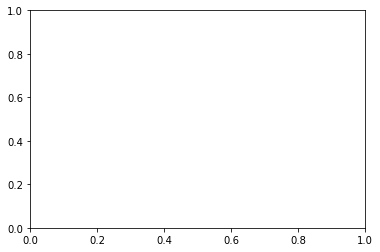

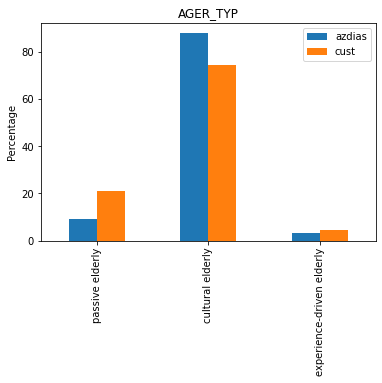

In [8]:
fig,ax=plt.subplots()
v1=dff['AGER_TYP'].value_counts().sort_index()/r1*100
v2=dff1['AGER_TYP'].value_counts().sort_index()/r2*100
pp1=pd.DataFrame({'azdias':v1, 'cust':v2})
ax=pp1.plot.bar(rot=0)
x=[0,1,2]
label=['passive elderly',
'cultural elderly',
'experience-driven elderly']
plt.xticks(x,label,rotation=90)
plt.ylabel("Percentage")
plt.title("AGER_TYP")

### The Azdias data has more cultural elderly percentage than customer data. Passive elderly people are more in customer data than azdias data. The least percentage of people are in experience-driven elderly in both the data sets. 

### Compare the Last Transaction Activity

Text(0.5, 1.0, 'LAST TRANSACTION ACTIVITY')

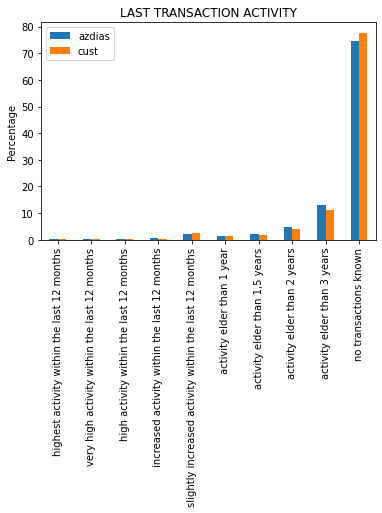

In [9]:
v1=dff['D19_TELKO_DATUM'].value_counts().sort_index()/r1*100
v2=dff1['D19_TELKO_DATUM'].value_counts().sort_index()/r2*100
pp1=pd.DataFrame({'azdias':v1, 'cust':v2})

ax=pp1.plot.bar(rot=0)
x=[0,1,2,3,4,5,6,7,8,9]
label=['highest activity within the last 12 months',
'very high activity within the last 12 months',
'high activity within the last 12 months',
'increased activity within the last 12 months',
'slightly increased activity within the last 12 months',
'activity elder than 1 year',
'activity elder than 1,5 years',
'activity elder than 2 years',
'activity elder than 3 years',
'no transactions known']
plt.xticks(x,label,rotation=90)
plt.ylabel("Percentage")
plt.title("LAST TRANSACTION ACTIVITY")

### Compare the Vacation habits of both the dataset

Text(0.5, 1.0, 'Vacation Habits')

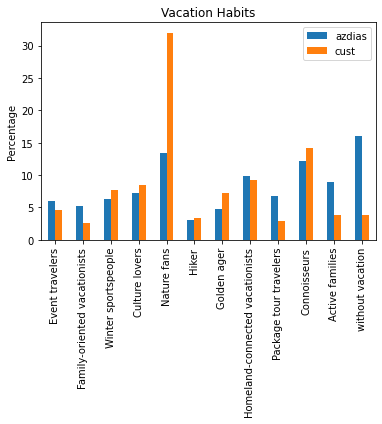

In [10]:
### The majority vaccation habits of the population and the azdias group is Nature Fans

v1=dff['GFK_URLAUBERTYP'].value_counts().sort_index()/r1*100
v2=dff1['GFK_URLAUBERTYP'].value_counts().sort_index()/r2*100

pp1=pd.DataFrame({'azdias':v1, 'cust':v2})

ax=pp1.plot.bar(rot=0)
x=[0,1,2,3,4,5,6,7,8,9,10,11]
label=['Event travelers','Family-oriented vacationists','Winter sportspeople',
'Culture lovers',
'Nature fans',
'Hiker',
'Golden ager',
'Homeland-connected vacationists',
'Package tour travelers',
'Connoisseurs',
'Active families',
'without vacation']
plt.xticks(x,label,rotation=90)
plt.ylabel("Percentage")
plt.title("Vacation Habits")

### The vacation habits of customer data has the highest perentage for Nature fans whereas azdias people prefer no vacation the most. 

### Compare the Industrial areas

Text(0.5, 1.0, 'INDUSTRIAL AREAS')

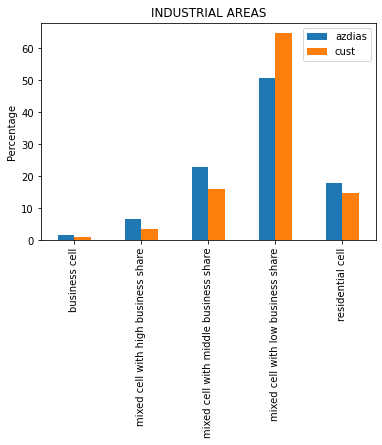

In [11]:
### The industrial area of the azdias and the population is mixed cell with low business share

v1=dff['GEBAEUDETYP_RASTER'].value_counts().sort_index()/r1*100
v2=dff1['GEBAEUDETYP_RASTER'].value_counts().sort_index()/r2*100
pp1=pd.DataFrame({'azdias':v1, 'cust':v2})

ax=pp1.plot.bar(rot=0)
x=[0,1,2,3,4]
label=['business cell','mixed cell with high business share','mixed cell with middle business share','mixed cell with low business share','residential cell']
plt.xticks(x,label,rotation=90)
plt.ylabel("Percentage")
plt.title("INDUSTRIAL AREAS")

### The azdias and customer data have higher percentage of mixed cell with low business share as the industrial area and business cell as the least. 

### Compare the Financial type 

Text(0.5, 1.0, 'FINANCIAL TYPE')

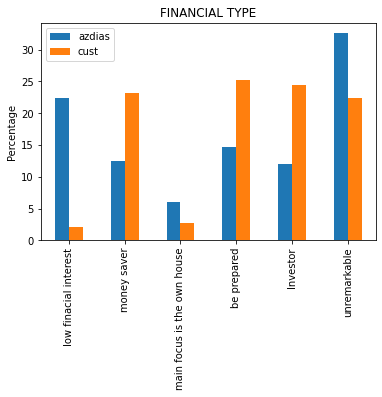

In [12]:
### The Financial type of azdias is unremarkable and that of the population is money safer and investor.

v1=dff['FINANZTYP'].value_counts().sort_index()/r1*100
v2=dff1['FINANZTYP'].value_counts().sort_index()/r2*100
pp1=pd.DataFrame({'azdias':v1, 'cust':v2})

ax=pp1.plot.bar(rot=0)
x=[0,1,2,3,4,5]
label=['low finacial interest','money saver','main focus is the own house','be prepared','Investor','unremarkable']
plt.xticks(x,label,rotation=90)
plt.ylabel("Percentage")
plt.title("FINANCIAL TYPE")

### The financial type of customer data is 'to be prepared' as the highest percentage whereas for customer data, the financial type is 'unremarkable'. The azdias data has higher percentage of 'low financial interest' compared to customer data which has the lowest percentage for 'low financial interest'.

### Compare the Car owners age

Text(0.5, 1.0, 'CAR OWNERS AGE')

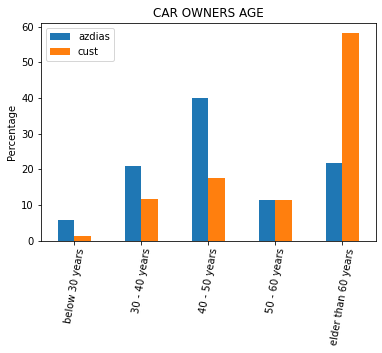

In [13]:
### The majority of the car owners age of azdias group is 40-50 years  and of the population is elder than 60 years.

v1=dff['KBA05_MAXAH'].value_counts().sort_index()/r1*100
v2=dff1['KBA05_MAXAH'].value_counts().sort_index()/r2*100
pp1=pd.DataFrame({'azdias':v1, 'cust':v2})

ax=pp1.plot.bar(rot=0)
x=[0,1,2,3,4]
label=['below 30 years','30 - 40 years','40 - 50 years','50 - 60 years','elder than 60 years']
plt.xticks(x,label,rotation=80)
plt.ylabel("Percentage")
plt.title("CAR OWNERS AGE")

### The customer data has higher percentage of elderly people more than 60 years as car owners whereas azdias data has higher percentage of people in the age 40-50 years as car owners. 

### Compare the Upper Class Cars

Text(0.5, 1.0, 'UPPER CLASS CARS')

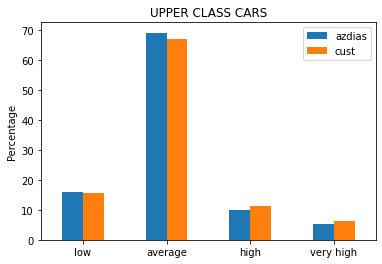

In [14]:
# Comparison of share of Upper Class cars 

v1=dff['KBA05_MOD1'].value_counts().sort_index()/r1*100
v2=dff1['KBA05_MOD1'].value_counts().sort_index()/r2*100
pp1=pd.DataFrame({'azdias':v1, 'cust':v2})
ax=pp1.plot.bar(rot=0)
x=[0,1,2,3]
label=['low','average','high','very high']
plt.xticks(x,label)
plt.ylabel("Percentage")
plt.title("UPPER CLASS CARS")

### The azdias and the customer data has higher percentage of average upper class cars, followed by low upper class cars and lowest percentage of very high upper class cars.

### Compare the Purchasing power 

Text(0.5, 1.0, 'PURCHASING POWER')

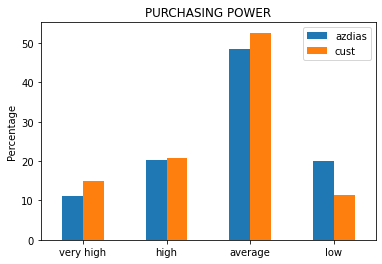

In [15]:
### The purchasing power of majority of azdias and the population is average.

v1=dff['KKK'].value_counts().sort_index()/r1*100
v2=dff1['KKK'].value_counts().sort_index()/r2*100
pp1=pd.DataFrame({'azdias':v1, 'cust':v2})
label=['very high','high','average','low']
ax=pp1.plot.bar(rot=0)
x=[0,1,2,3]
plt.xticks(x,label)
plt.ylabel("Percentage")
plt.title("PURCHASING POWER")

### The highest purchasing power of both azdias and customer data is 'average'. The azdias data has lowest percentage of 'very high' purchasing power and the customer data has lowest percentage of 'low' purchasing power. 

# Transform the Dataset

### Transform the Azdias dataset by using MinMax Normalization  
###  and reduce the dimension using PCA

The data is normalized using Min Max normalization


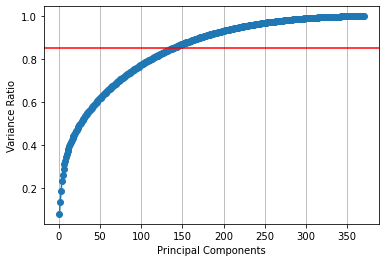

10 components explain 0.3583114351233094 of variance.
20 components explain 0.45616190770893755 of variance.
30 components explain 0.5224152626774895 of variance.
40 components explain 0.573984731004912 of variance.
50 components explain 0.6170517280245157 of variance.
60 components explain 0.6553590523441606 of variance.
70 components explain 0.6897458372458201 of variance.
80 components explain 0.7204875612259809 of variance.
90 components explain 0.747951674533444 of variance.
100 components explain 0.773146495890075 of variance.
110 components explain 0.7962306500131858 of variance.
120 components explain 0.8171156559985242 of variance.
130 components explain 0.8362245148151428 of variance.
140 components explain 0.8538856187300559 of variance.
150 components explain 0.8701564273248419 of variance.
160 components explain 0.8851020300352713 of variance.
170 components explain 0.8986717876093052 of variance.
180 components explain 0.9108655820826664 of variance.
190 components explai

In [17]:
df2=transformation(dff)

### The number of components require to explain 87% of variance is 150 and hence PCA with 150 components are used to fit the dataset and a reduced representation of the data is obtained. 

In [19]:
df2.head()

,LNR,D19_BILDUNG,ANREDE_KZ,VHA,D19_VOLLSORTIMENT,RT_SCHNAEPPCHEN,KBA13_HERST_FORD_OPEL,D19_REISEN,KBA05_ALTER3,D19_BANKEN_GROSS,...,class_7,KBA13_FORD,D19_VERSICHERUNGEN,KBA05_MOD8,SEMIO_SOZ,CJT_GESAMTTYP,GEBURTSJAHR,KBA13_KW_90,direction_O,KBA13_BJ_2008
0,0.806268,0.000000,0.0,0.0,0.0,0.75,0.50,0.000000,0.50,0.000000,...,0.0,0.50,0.000000,0.0,0.166667,0.2,0.000000,0.50,0.0,0.50
1,0.806273,0.000000,1.0,0.0,0.0,0.50,0.25,0.000000,0.00,0.000000,...,0.0,0.25,0.000000,0.0,0.666667,0.8,0.989588,0.50,0.0,0.50
2,0.806279,0.857143,1.0,0.0,1.0,0.75,0.50,0.000000,0.50,0.000000,...,0.0,0.75,0.000000,0.0,0.500000,0.4,0.981160,0.25,0.0,0.50
3,0.806280,0.000000,1.0,0.2,0.0,0.25,0.25,0.857143,0.50,0.000000,...,0.0,0.50,0.000000,0.0,0.666667,0.2,0.970253,0.50,0.0,0.75
4,0.806297,0.857143,0.0,0.0,0.0,1.00,0.50,0.000000,0.75,0.333333,...,0.0,0.75,0.428571,0.5,0.833333,0.8,0.973228,0.50,0.0,0.50


In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 97 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   LNR                    891221 non-null  float64
 1   D19_BILDUNG            891221 non-null  float64
 2   ANREDE_KZ              891221 non-null  float64
 3   VHA                    891221 non-null  float64
 4   D19_VOLLSORTIMENT      891221 non-null  float64
 5   RT_SCHNAEPPCHEN        891221 non-null  float64
 6   KBA13_HERST_FORD_OPEL  891221 non-null  float64
 7   D19_REISEN             891221 non-null  float64
 8   KBA05_ALTER3           891221 non-null  float64
 9   D19_BANKEN_GROSS       891221 non-null  float64
 10  FINANZ_HAUSBAUER       891221 non-null  float64
 11  D19_KINDERARTIKEL      891221 non-null  float64
 12  UMFELD_JUNG            891221 non-null  float64
 13  D19_SONSTIGE           891221 non-null  float64
 14  D19_SOZIALES           891221 non-nu

### Transform the Customer dataset by using MinMax Normalization  
###  and reduce the dimension using PCA

The data is normalized using Min Max normalization


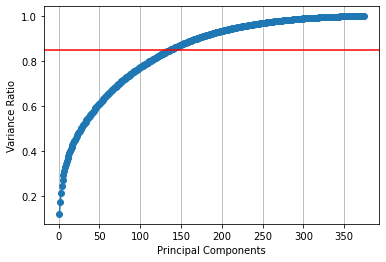

10 components explain 0.358090336624621 of variance.
20 components explain 0.4524455081455376 of variance.
30 components explain 0.5156933178915248 of variance.
40 components explain 0.5670861218549259 of variance.
50 components explain 0.6123520535758508 of variance.
60 components explain 0.6525186159626581 of variance.
70 components explain 0.6878317889866895 of variance.
80 components explain 0.7194929344096752 of variance.
90 components explain 0.7476663622984763 of variance.
100 components explain 0.7733573314974306 of variance.
110 components explain 0.7967290421206499 of variance.
120 components explain 0.8183119497519593 of variance.
130 components explain 0.8381802558082642 of variance.
140 components explain 0.856428758861532 of variance.
150 components explain 0.8731644362802531 of variance.
160 components explain 0.888378155278001 of variance.
170 components explain 0.9021053835175671 of variance.
180 components explain 0.9142128567095044 of variance.
190 components explain

In [21]:
df3=transformation(dff1)

### The number of components require to explain 87% of variance is 150 and hence PCA with 150 components are used to fit the dataset and a reduced representation of the data is obtained. 

In [22]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 98 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   LNR                     191652 non-null  float64
 1   D19_BILDUNG             191652 non-null  float64
 2   ANREDE_KZ               191652 non-null  float64
 3   KBA05_HERST5            191652 non-null  float64
 4   AGER_TYP                191652 non-null  float64
 5   VHA                     191652 non-null  float64
 6   D19_VOLLSORTIMENT       191652 non-null  float64
 7   KK_KUNDENTYP            191652 non-null  float64
 8   KBA13_BJ_2006           191652 non-null  float64
 9   D19_REISEN              191652 non-null  float64
 10  HH_EINKOMMEN_SCORE      191652 non-null  float64
 11  D19_BANKEN_GROSS        191652 non-null  float64
 12  D19_RATGEBER            191652 non-null  float64
 13  D19_KINDERARTIKEL       191652 non-null  float64
 14  UMFELD_JUNG         

In [47]:
inter=list(set(df2.columns.to_list()).intersection(set(df3.columns.to_list())))
inter

['class_5',
 'D19_BILDUNG',
 'KKK',
 'KBA05_MAXBJ',
 'KBA13_KMH_251',
 'D19_VERSAND_REST',
 'VERS_TYP',
 'HH_DELTA_FLAG',
 'ANREDE_KZ',
 'KBA13_KMH_140',
 'VHA',
 'D19_BUCH_CD',
 'KBA05_KRSKLEIN',
 'D19_BANKEN_DIREKT',
 'UMFELD_ALT',
 'KBA13_CCM_1800',
 'KBA05_SEG7',
 'D19_SONSTIGE.1',
 'KBA13_CCM_1500',
 'D19_VOLLSORTIMENT',
 'KBA13_CCM_1600',
 'class_8',
 'KBA13_KMH_110',
 'KONSUMZELLE',
 'KBA13_MOTOR',
 'class_2',
 'D19_DROGERIEARTIKEL',
 'D19_TECHNIK',
 'HEALTH_TYP',
 'GREEN_AVANTGARDE',
 'KBA05_SEG1',
 'GEBAEUDETYP',
 'KBA05_ALTER1',
 'D19_TELKO_REST',
 'D19_REISEN',
 'KBA13_KRSZUL_NEU',
 'KBA13_CCM_3001',
 'KBA05_MOTRAD',
 'GFK_URLAUBERTYP',
 'class_7',
 'D19_BANKEN_GROSS',
 'KBA13_KMH_0_140',
 'D19_HAUS_DEKO',
 'class_6',
 'D19_KINDERARTIKEL',
 'UMFELD_JUNG',
 'KBA05_FRAU',
 'KBA13_FORD',
 'D19_LOTTO',
 'KBA13_NISSAN',
 'D19_SONSTIGE',
 'D19_VERSICHERUNGEN',
 'KBA05_MOD8',
 'SHOPPER_TYP',
 'SEMIO_SOZ',
 'D19_SOZIALES',
 'D19_FREIZEIT',
 'cluster',
 'KBA05_ANHANG',
 'D19_BANKEN_R

## Cluster the Data using KMeans Clustering

### The next step would be to cluster the datapoints to find the segmentation of the population. Before applying the cluster method, the number of clusters is tobe determined. The Elbow method is a very popular technique and the idea is to run k-means clustering for a range of clusters k (let’s say from 1 to 10) and for each value, we are calculating the sum of squared distances from each point to its assigned center(distortions). When the distortions are plotted and the plot looks like an arm then the “elbow”(the point of inflection on the curve) is the best value of k.

### Cluster the Azdias Dataset

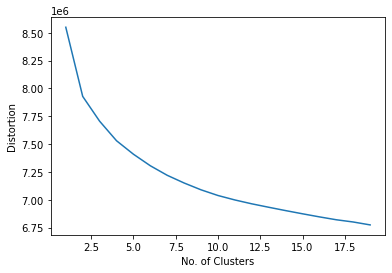

Enter the no, of clusters seeing the graph from Elbow method : 8
The number of clusters passed as parameter to KMeans Clustering is  8


In [23]:
clust_az=segmentation(df2)

### The point of inflection on the curve is 8 and hence KMeans clustering method clusters the dataset into 8 clusters 

Text(0.5, 1.0, 'Azdias')

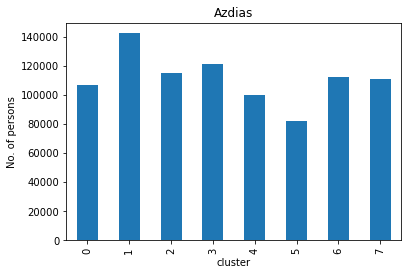

In [122]:
cc1=clust_az.groupby('cluster')['LNR'].count()
cc1.plot(kind='bar')
plt.ylabel('No. of persons')
plt.title('Azdias')

### Cluster -7 has the highest number of people followed by cluster-4 and cluster-6. Cluster-0 has the least number of people.

### Cluster the Customer Dataset

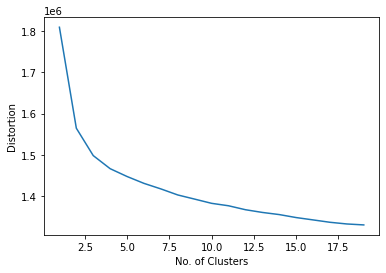

Enter the no, of clusters seeing the graph from Elbow method : 8
The number of clusters passed as parameter to KMeans Clustering is  8


In [25]:
clust_ct=segmentation(df3)

### The point of inflection on the curve is 8 and hence KMeans clustering method clusters the dataset into 8 clusters 

Text(0.5, 1.0, 'Customer')

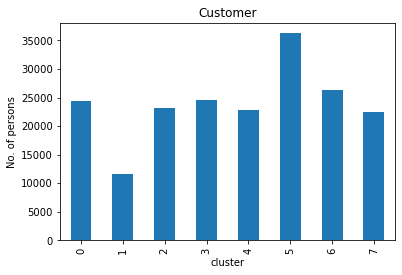

In [123]:
cc=clust_ct.groupby('cluster')['LNR'].count()
cc.plot(kind='bar')
plt.ylabel('No. of persons')
plt.title('Customer')

### Cluster-6 has the highest number of people followed by cluster-3 and cluster-5. Cluster-7 has the least number of people.

## Compare the Clusters of Azdias and Customer Dataset

In [178]:
int_col=['D19_TELKO_REST','KBA13_CCM_1800','HEALTH_TYP','GFK_URLAUBERTYP','KKK','HEALTH_TYP']
cl_cols=['class_2','class_4','class_5','class_6','class_7','class_8']

In [179]:
cl=list(set(clust_az.columns) & set(clust_ct.columns))
cl

['class_5',
 'D19_BILDUNG',
 'KKK',
 'KBA05_MAXBJ',
 'KBA13_KMH_251',
 'D19_VERSAND_REST',
 'VERS_TYP',
 'HH_DELTA_FLAG',
 'ANREDE_KZ',
 'KBA13_KMH_140',
 'VHA',
 'D19_BUCH_CD',
 'KBA05_KRSKLEIN',
 'D19_BANKEN_DIREKT',
 'UMFELD_ALT',
 'KBA13_CCM_1800',
 'KBA05_SEG7',
 'D19_SONSTIGE.1',
 'KBA13_CCM_1500',
 'D19_VOLLSORTIMENT',
 'KBA13_CCM_1600',
 'class_8',
 'KBA13_KMH_110',
 'KONSUMZELLE',
 'KBA13_MOTOR',
 'class_2',
 'D19_DROGERIEARTIKEL',
 'D19_TECHNIK',
 'HEALTH_TYP',
 'GREEN_AVANTGARDE',
 'KBA05_SEG1',
 'GEBAEUDETYP',
 'KBA05_ALTER1',
 'D19_TELKO_REST',
 'D19_REISEN',
 'KBA13_KRSZUL_NEU',
 'KBA13_CCM_3001',
 'KBA05_MOTRAD',
 'GFK_URLAUBERTYP',
 'class_7',
 'D19_BANKEN_GROSS',
 'KBA13_KMH_0_140',
 'D19_HAUS_DEKO',
 'class_6',
 'D19_KINDERARTIKEL',
 'UMFELD_JUNG',
 'KBA05_FRAU',
 'KBA13_FORD',
 'D19_LOTTO',
 'KBA13_NISSAN',
 'D19_SONSTIGE',
 'D19_VERSICHERUNGEN',
 'KBA05_MOD8',
 'SHOPPER_TYP',
 'SEMIO_SOZ',
 'D19_SOZIALES',
 'D19_FREIZEIT',
 'cluster',
 'KBA05_ANHANG',
 'D19_BANKEN_R

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [180]:
#cols=['AGER_TYP','ANREDE_KZ','D19_TELKO_DATUM','GFK_URLAUBERTYP','FINANZTYP','KKK','KBA05_MAXAH','KBA05_MOD1','ONLINE_AFFINITAET']
cl_cols1=['upper middleclass',
'consumption-oriented middleclass', 
'active middleclass', 
'low-consumption middleclass',
'lower middleclass',
'working class',
]

In [181]:
d11=clust_az[clust_az['cluster']==1]
d21=clust_az[clust_az['cluster']==0]
d31=clust_az[clust_az['cluster']==2]
d11.drop('cluster',axis=1,inplace=True)
d21.drop('cluster',axis=1,inplace=True)
d31.drop('cluster',axis=1,inplace=True)

In [182]:
pl1=list(round(np.mean(d11[int_col]),2))
p21=list(round(np.mean(d21[int_col]),2))
p31=list(round(np.mean(d31[int_col]),2))


In [183]:
d1=clust_ct[clust_ct['cluster']==5]
d2=clust_ct[clust_ct['cluster']==6]
d3=clust_ct[clust_ct['cluster']==3]
d1.drop('cluster',axis=1,inplace=True)
d2.drop('cluster',axis=1,inplace=True)
d3.drop('cluster',axis=1,inplace=True)
pl=list(round(np.mean(d1[int_col]),2))
p2=list(round(np.mean(d2[int_col]),2))
p3=list(round(np.mean(d3[int_col]),2))


Text(0.5, 1.0, 'Azdias')

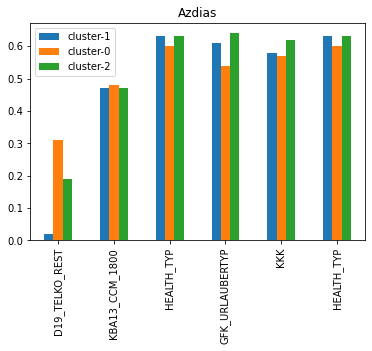

In [186]:
p1=pd.DataFrame({'cluster-1':pl1,'cluster-0':p21,'cluster-2':p31})
p1.plot.bar(rot=0)
#plt.bar(cols,pl,color='r',width=w)
#plt.bar(cols,p2,color='g',width=w)
plt.legend()
x=[0,1,2,3,4,5]
label=int_col
plt.xticks(x,label,rotation=90)
plt.title('Azdias')

### 

### 

In [187]:
pl11=list(round(np.mean(d11[cl_cols]),2))
pl21=list(round(np.mean(d21[cl_cols]),2))
pl31=list(round(np.mean(d31[cl_cols]),2))

Text(0.5, 1.0, 'Customer')

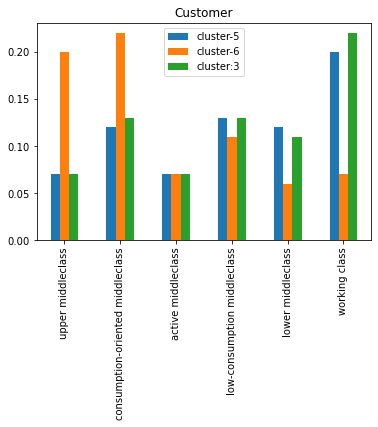

In [188]:
p1=pd.DataFrame({'cluster-5':pl11,'cluster-6':pl21,'cluster:3':pl31})
#fig,ax=plt.subplots()


p1.plot.bar(rot=0)

#plt.legend()
x=[0,1,2,3,4,5]
label=cl_cols1
plt.xticks(x,label,rotation=90)
plt.title('Customer')

### 

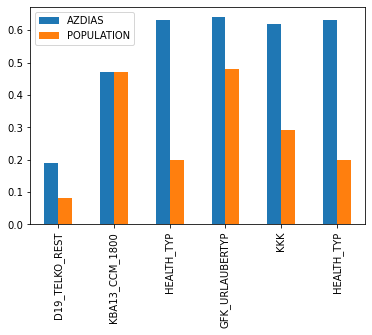

In [190]:
pc=pd.DataFrame({'AZDIAS':p31,'POPULATION':p2})
#fig,ax=plt.subplots()
#w=0.2
#ax=
pc.plot.bar(rot=0)
#plt.bar(cols,pl,color='r',width=w)
#plt.bar(cols,p2,color='g',width=w)
plt.legend()
x=[0,1,2,3,4,5]
label=int_col
plt.xticks(x,label,rotation=90)
plt.show()

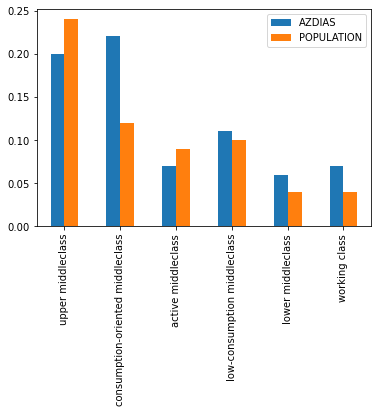

In [191]:
p=pd.DataFrame({'AZDIAS':pl21,'POPULATION':pl2})
p.plot.bar(rot=0)
#plt.bar(cols,pl,color='r',width=w)
#plt.bar(cols,p2,color='g',width=w)
#plt.legend()
x=[0,1,2,3,4,5]
label=cl_cols1
plt.xticks(x,label,rotation=90)
plt.show()

### General characteristics found in the cluster of Azdias data:
### - The individuals in the cluster have high share of cars with 1600ccm
### - The individuals are jaunty hedonists in heath_typ.
### - The German people prefer no vacation 
### - The individuals have low purchasing power.
### - The individuals belong to consumption oriented middle class.

## Supervised Modeling

### Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

### The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [4]:
## Load Training Data

df_t=pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv',sep=';')
df_t

C:\Users\deepa\AppData\Local\Temp\ipykernel_15040\4170259015.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_t=pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv',sep=';')


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,66338,2,1.0,0.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,1.0,1.0,4.0,8.0,7.0,1,0,1,4
42958,67629,-1,1.0,0.0,NaN,NaN,NaN,NaN,14.0,1.0,...,1.0,1.0,1.0,5.0,9.0,7.0,1,0,1,3
42959,68273,1,1.0,16.0,NaN,NaN,NaN,NaN,10.0,2.0,...,1.0,2.0,1.0,2.0,9.0,7.0,1,0,1,4
42960,68581,2,1.0,18.0,NaN,NaN,NaN,NaN,13.0,3.0,...,2.0,3.0,4.0,2.0,9.0,2.0,3,0,2,4


In [5]:
df_t.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

Text(0.5, 0, 'RESPONSE')

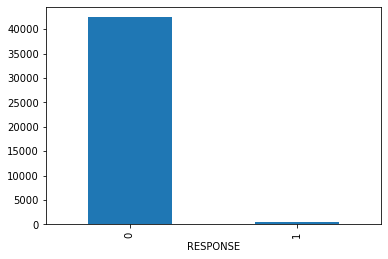

In [6]:
df_t.RESPONSE.value_counts().plot(kind='bar')
plt.xlabel('RESPONSE')

In [7]:
y=df_t.RESPONSE
df_t.drop('RESPONSE',axis=1,inplace=True)

### Clean the mail_train dataset

In [10]:
df_clean=clean_data(df_t)

df_clean.shape

Columns with 80% missing values are removed
Unknown values are replaced by numpy nan values
Simple Imputer with "most_frequent" as the strategy is used to fill missing values
Highly correlated features are determined using pearsons correlation and removed
The following categorical attributes are converted to dummy variables  ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']


(42962, 378)

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 378 entries, LNR to year
dtypes: float64(244), int64(79), uint8(55)
memory usage: 108.1 MB


In [12]:
df_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,D19_TELKO_REST,D19_TIERARTIKEL,D19_UNBEKANNT,D19_VERSAND_REST,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,direction_O,direction_W,year
0,1763,2.0,1.0,8.0,8.0,0.0,0.0,1.0,0.0,3.0,...,0,0,1,0,0,0,0,0,1,1992
1,1771,1.0,4.0,13.0,13.0,0.0,0.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0,0,1,1997
2,1776,1.0,1.0,10.0,7.0,0.0,0.0,0.0,0.0,4.0,...,0,0,0,0,0,0,0,1,0,1995
3,1460,2.0,1.0,6.0,6.0,0.0,0.0,2.0,0.0,4.0,...,0,0,1,0,0,0,0,0,1,1992
4,1783,2.0,1.0,10.0,9.0,0.0,0.0,1.0,0.0,3.0,...,0,0,0,0,0,0,0,0,1,1992


In [13]:
df_clean.isnull().sum()

LNR                     0
AGER_TYP                0
AKT_DAT_KL              0
ALTER_HH                0
ALTERSKATEGORIE_FEIN    0
                       ..
D19_VOLLSORTIMENT       0
D19_WEIN_FEINKOST       0
direction_O             0
direction_W             0
year                    0
Length: 378, dtype: int64

In [14]:
X=df_clean
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

### GradientBoostingClassifier

In [15]:
### GradientBoostingClassifier

clf=GradientBoostingClassifier()
clf.get_params()
#build_model(AdaBoostClassifier(n_estimators=40,learning_rate=0.25,'base_estimator__max_depth': [1, 3],'base_estimator__max_features': [20, None]))

param_grid={'learning_rate':[0.1,0.3], 'max_depth':[4,5]}
gr=GridSearchCV(clf,param_grid,scoring='roc_auc')

gr.fit(X_train,y_train)

gr.best_score_

0.7370334592287979

### MLPClassifier

In [93]:
clf=MLPClassifier()
clf.get_params()

param_grid={'learning_rate':['adaptive'], 'max_iter':[100],'early_stopping':[True],'validation_fraction':[0.4] }
gr=GridSearchCV(clf,param_grid,scoring='roc_auc')

gr.fit(X_train,y_train)

gr.best_score_

0.4965661842756302

## SVM

In [94]:
from sklearn import svm
clf=svm.SVC()
clf.get_params()

grid_params={'kernel':['sigmoid'],'class_weight':['balanced']}
gr=GridSearchCV(clf,grid_params,scoring='roc_auc')

gr.fit(X_train,y_train)

gr.best_score_

0.48265755661392473

### DecisionTreeClassifier

In [95]:
clf=DecisionTreeClassifier()
clf.get_params()

param_grid={'criterion':['entropy'],'splitter':['random'],'max_depth':[5]}
gr=GridSearchCV(clf,param_grid,scoring='roc_auc')

gr.fit(X_train,y_train)

gr.best_score_

0.7508359926874553

### SGDClassifier

In [96]:
clf=SGDClassifier()
clf.get_params()

grid_params={'loss':['modified_huber'],'alpha':[0.005],'max_iter':[2000]}
gr=GridSearchCV(clf,grid_params,scoring='roc_auc')

gr.fit(X_train,y_train)

gr.best_score_

0.5106061511041197

### KNeighborsClassifier

In [97]:
clf=KNeighborsClassifier()
clf.get_params()

grid_params={'weights':['distance'],'algorithm':['auto'],'p':[1]}
gr=GridSearchCV(clf,grid_params,scoring='roc_auc')

gr.fit(X_train,y_train)

gr.best_score_

0.5010257661876873

### AdaBoostClassifier

In [98]:
### AdaBoostClassifier

clf=AdaBoostClassifier()
clf.get_params()

param_grid={'learning_rate':[0.1,0.3], 'n_estimators':[80]}
gr=GridSearchCV(clf,param_grid,scoring='roc_auc')

gr.fit(X_train,y_train)

gr.best_score_

0.7536739857782676

In [99]:
# Vary the parameters
param_grid={'learning_rate':[0.1,0.2], 'n_estimators':[50]}
gr=GridSearchCV(clf,param_grid,scoring='roc_auc')

gr.fit(X_train,y_train)

ada_best=gr.best_estimator_

In [100]:
gr.best_score_

0.7661755154516611

In [34]:
p=pd.DataFrame({'GradientBoosting':[0.73921],'MLPClassifier':[0.4965],'SVM':[0.48265],'DecisionTree':[0.7508],'SGDClassifier':[0.5106],'KNeighbors':[0.5010],'Adaboost':[0.7661]})

p

,GradientBoosting,MLPClassifier,SVM,DecisionTree,SGDClassifier,KNeighbors,Adaboost
0,0.73921,0.4965,0.48265,0.7508,0.5106,0.501,0.7661


Text(0.5, 1.0, 'Performance of different models')

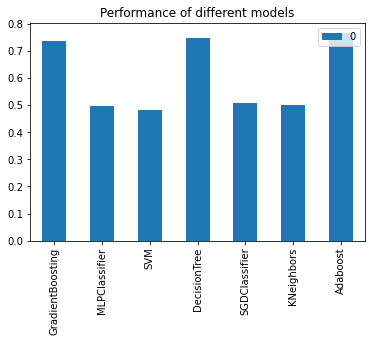

In [32]:
p.transpose().plot.bar()
plt.legend()
plt.title('Performance of different models')

In [104]:
imp=ada_best.feature_importances_

feature_importance_values= np.zeros((len(ada_best.feature_importances_)))
    
feature_importance_values += ada_best.feature_importances_

imp=pd.DataFrame({'Feature':X.columns,'Importance':feature_importance_values})


In [105]:
srt=imp.sort_values('Importance',ascending=False)[:7]
srt

,Feature,Importance
54,D19_SOZIALES,0.68
44,D19_KONSUMTYP_MAX,0.12
283,PRAEGENDE_JUGENDJAHRE,0.06
11,CJT_GESAMTTYP,0.06
148,KBA05_SEG2,0.04
77,EINGEZOGENAM_HH_JAHR,0.02
13,CJT_TYP_1,0.02


0.7661755154516611

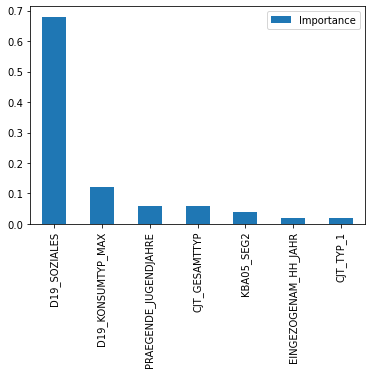

In [106]:
srt.plot(kind='bar')
x=np.arange(0,7,1)
plt.xticks(x,list(srt['Feature']))

gr.best_score_

In [107]:
param_grid={'learning_rate':[0.1,0.25], 'n_estimators':[60]}
gr=GridSearchCV(clf,param_grid,scoring='roc_auc')
gr.fit(X_train,y_train)

gr.best_score_

0.7627713907876956

## Load Test Data

In [108]:
df_test=pd.read_csv('Udacity_MAILOUT_052018_TEST.csv',sep=';',low_memory=False)
df_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


### Clean the Test Data

In [109]:
df_test1=clean_data(df_test)

Columns with 80% missing values are removed
Unknown values are replaced by numpy nan values
Simple Imputer with "most_frequent" as the strategy is used to fill missing values
Highly correlated features are determined using pearsons correlation and removed
The following categorical attributes are converted to dummy variables  ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']


In [ ]:
df_azdias=pd.read_csv("Udacity_AZDIAS_052018.csv",sep=";",low_memory=False)

In [110]:
diff=list(set(df_test1.columns)-set(X.columns))
diff

['KBA13_ANTG1', 'PLZ8_ANTG1']

In [115]:
diff1=list(set(X.columns)-set(df_test1.columns))
X.drop(diff1,axis=1,inplace=True)

In [111]:
df_test1.drop(diff,axis=1,inplace=True)

In [116]:
print(X.shape)

print(df_test1.shape)

(42962, 370)
(42833, 370)


In [117]:
ada_best.fit(X,y)

pred=ada_best.predict(df_test1)

In [118]:
pr=ada_best.predict_proba(df_test1)[:,1]
pr

array([0.32416532, 0.32757171, 0.24380453, ..., 0.32577115, 0.30756824,
       0.3208186 ])

In [119]:
pr[:1]

array([0.32416532])

In [121]:
ind=df_test1['LNR']
df_pred=pd.DataFrame(index=ind)
df_pred['Response']=pr
df_pred.head(10)

,Response
LNR,
1754,0.324165
1770,0.327572
1465,0.243805
1470,0.247456
1478,0.260339
1782,0.245317
1485,0.256783
1519,0.325771
1835,0.327572


In [120]:
df_pred.describe()

,Response
count,42833.000000
mean,0.278459
std,0.033866
min,0.234973
25%,0.245797
50%,0.262929
75%,0.309129
max,0.336936
